# Objective: Learn to do clustering and noise reduction in data using PCA 

In [128]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd 
from sklearn.datasets import load_digits

digits = load_digits()

## PCA using SVD

In [129]:
def PCA(X, do_mean_centering=False):
    if do_mean_centering:
        X_mean_centered = np.zeros_like(X)
        for col in range(X_mean_centered.shape[1]):
            X_col = X[:, col]
            X_mean_centered[:, col] = X_col - np.mean(X_col)
        X = X_mean_centered
        
    U, S, PT = svd(X, full_matrices=False)
    Sigma = np.diag(S)
    T = np.dot(U, Sigma)
    return T, PT.T, Sigma # Score, Loadings, Variance

In [130]:
def plot_digits(data):
    fig, axes = plt.subplots(
        4, 10, figsize=(10, 4),
        subplot_kw={'xticks':[], 'yticks':[]},
        gridspec_kw=dict(hspace=0.1, wspace=0.1)
    )

    for i, ax in enumerate(axes.flat):
        ax.imshow(
            data[i].reshape(8, 8),
            cmap='binary', interpolation='nearest', clim=(0, 16)
        )

In [131]:
# Find out the original dimension of the data
X = digits.data
y = digits.target 

print("Shape of X", X.shape)
print("Shape of y", y.shape)

Shape of X (1797, 64)
Shape of y (1797,)


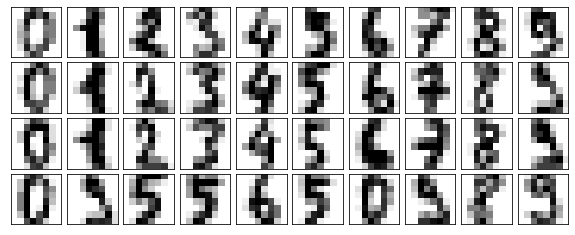

In [132]:
# Visualize the original data
plot_digits(X)

### Task 1: Dimensionality reduction: Conduct PCA on the the matrix $X$ to find out the dimension required to capture 80% of the variance

Required components/dimensions to explain 80.0% variance: 3
Required components/dimensions to explain 80.0% variance: 3


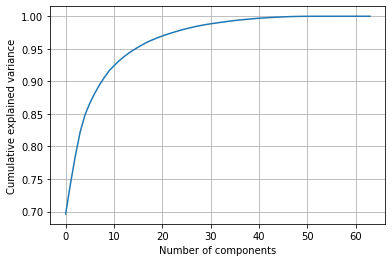

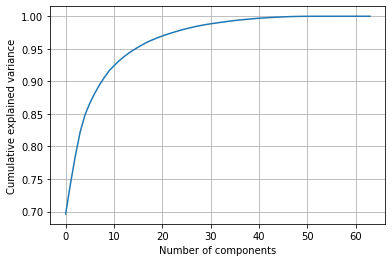

In [270]:
# TODO: Make plots comparing normalization to not
# Get variance explained by singular values
def conduct_PCA(X):
    n_samples = X.shape[0]
    T, P, Sigma = PCA(X)

    # Compute sample variance
    explained_variance = (Sigma ** 2) / (n_samples - 1)

    total_variance = explained_variance.sum()
    explained_variance_ratio = explained_variance / total_variance

    #cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    #explained_variance_threshold = 0.8
    #required_dimensions = np.argmax(cumulative_explained_variance > explained_variance_threshold)

    component_wise_sum = explained_variance_ratio.sum(axis=0)
    cumulative_explained_variance = np.cumsum(component_wise_sum)

    explained_variance_threshold = 0.8
    required_dimensions = np.argmax(cumulative_explained_variance > explained_variance_threshold)
    plt.figure()
    plt.plot(cumulative_explained_variance)
    plt.grid()
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance');
    print(f'Required components/dimensions to explain {explained_variance_threshold*100}% variance: {required_dimensions}')
    
conduct_PCA(X)
conduct_PCA(X / np.linalg.norm(X))

Using the "eyeballing" method to pinpoint the necessary dimension to capture a given amount of variance is not very precise when the dimensionality of the underlying data is *larger than it is here*. For data sets with eg. 100+ dimensions we could solve for the exact dimension that exceeds the set explained variance, say 80%, as

```
cumulative_explained = np.cumsum(explained_variance_ratio)
n_required_dims = np.argmax(cumulative_explained > 0.8)
```  
We can also specify the required amount of explained variance if we use e.g. sklearn's PCA implementation.

###  Task 2: Clustering: Project the original data matrix X on the first two PCs and draw the scalar plot 

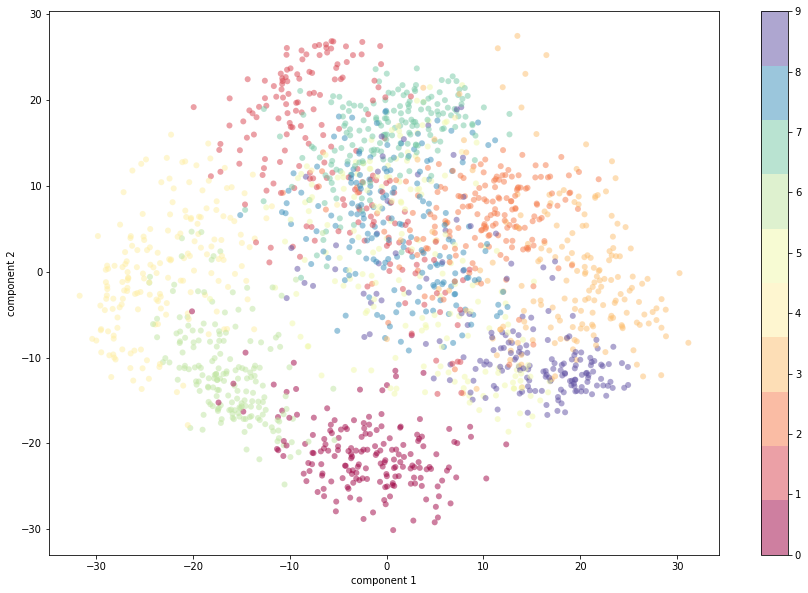

In [134]:
# Need mean centered data here to make more sense out of the plots
# Clustering without mean centering yields more overlap.

# Columns of T = U@S are principle components
T, _, _ = PCA(X, do_mean_centering=True)
t1 = T[:,0]
t2 = T[:,1]

plt.figure(figsize=(15, 10))
plt.scatter(
    t1, t2, c=digits.target, edgecolor='none', alpha=0.5,
    cmap=plt.cm.get_cmap('Spectral', 10)
)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### Task 3: Denoising: Remove noise from the noisy data

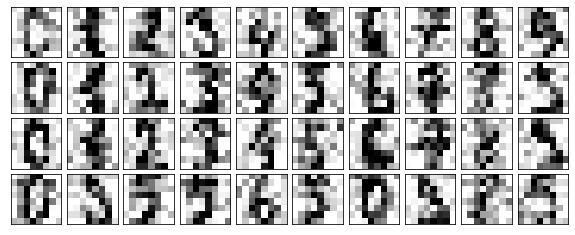

In [266]:
# Adding noise to the original data
X = digits.data
y = digits.target

np.random.seed(42)
noisy = np.random.normal(X, 4)

plot_digits(noisy)

Tips: 

* Decompose the noisy data using PCA 
* Reconstruct the data using just a few dominant components. For eg. check the variance plot 

Since the nature of the noise is more or less similar across all the digits, they are not the fearues with enough variance to discriminate between the digits. 

14


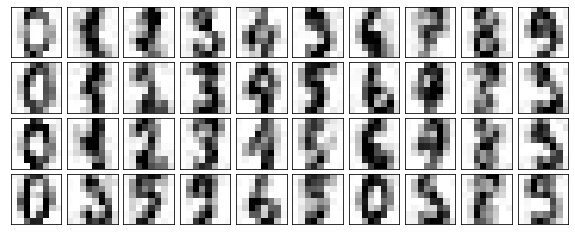

In [267]:
def denoise_signal(signal, do_mean_centering):
    T, P, Sigma = PCA(noisy, do_mean_centering)
    
    # Select how many components to use 
    explained_variance = (Sigma ** 2) / (signal.shape[0] - 1)
    total_variance = explained_variance.sum()
    explained_variance_ratio = explained_variance / total_variance
    
    component_wise_sum = explained_variance_ratio.sum(axis=0)
    cumulative_explained_variance = np.cumsum(component_wise_sum)
    
    explained_variance_threshold = 0.8
    required_dimensions = np.argmax(cumulative_explained_variance > explained_variance_threshold)
    print(required_dimensions)
    n_components = required_dimensions
    
    # Project data down to n principle components, then reconstruct the data based on this.
    noise_reduced = T[:, :n_components]
    noise_reconstructed = noise_reduced @ P[:, :n_components].T
    return noise_reconstructed

plot_digits(denoise_signal(noise, do_mean_centering=False))

### Task 4: Study the impact of normalization of the dataset before conducting PCA. Discuss if it is critical to normalize this particular data compared to the dataset in other notebooks

14


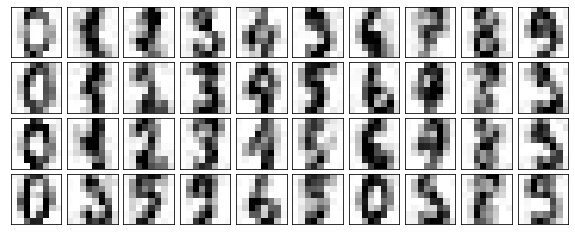

In [271]:
normalized_signal = noise / np.linalg.norm(noise)

plot_digits(denoise_signal(normalized_signal, do_mean_centering=False))

# Normalizing here does not yield any noticable improvement, if any.
# This is likely because of how each column in the dataset represent some
# part of the same source (image of the digits), and thus we should expect
# similar properties between each column. I.e we are not necessarily comparing apples and oranges :)

# See also Task 1 - normalization does not change anything.

## All the above excercises can be done using the sklearn library as follows

In [58]:
from sklearn.decomposition import PCA


X = digits.data
y = digits.target

(1797, 64)
(1797, 2)


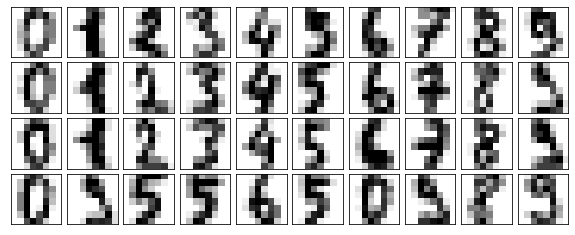

In [59]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)

print(digits.data.shape)
print(projected.shape)
plot_digits(digits.data)

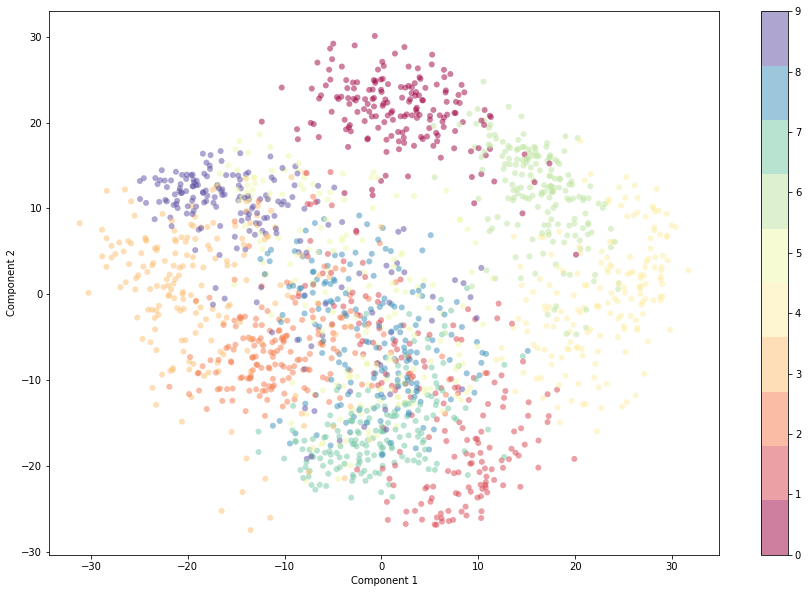

In [60]:
plt.figure(figsize=(15,10))
plt.scatter(
    projected[:, 0], projected[:, 1],
    c=digits.target, edgecolor='none', alpha=0.5,
    cmap=plt.cm.get_cmap('Spectral', 10)
)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar();

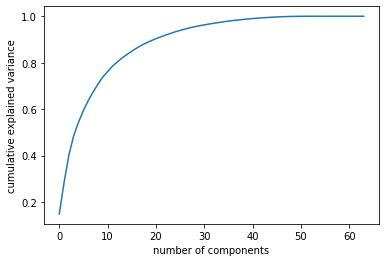

In [61]:
pca = PCA().fit(X)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

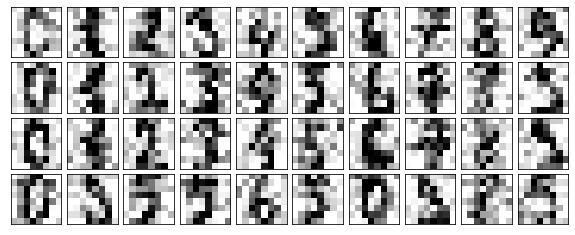

In [62]:
np.random.seed(42)

noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

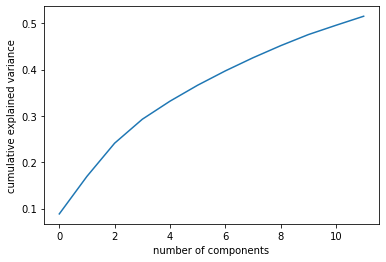

In [63]:
pca = PCA(0.50).fit(noisy) # 50% of the variance amounts to 12 principal components.

pca.n_components_
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

(1797, 64)


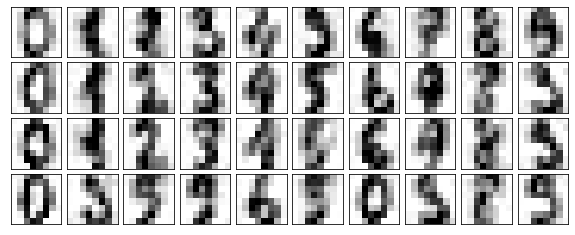

In [64]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)

plot_digits(filtered)